In [1]:
import config
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2

In [2]:
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

In [3]:
connect = psycopg2.connect(
    dbname=config.dbname,
    user=config.user,
    password=config.password,
    host=config.host,
    port=config.port
)
cur = connect.cursor()
query = '''
        SELECT timestamp, high_price
        FROM nvidia
        WHERE timestamp >= CURRENT_DATE - INTERVAL '3 years';
''' 
cur.execute(query)
results = cur.fetchall()
cur.close()
connect.close()

In [4]:
df = pd.DataFrame(results, columns=['Date', 'Max price'])
df.set_index('Date', inplace=True)
df.head()

,Max price
Date,
2024-04-08,922.2500
2024-03-28,974.0000
2024-02-29,823.9400
2024-01-31,634.9300
2023-12-29,504.3299


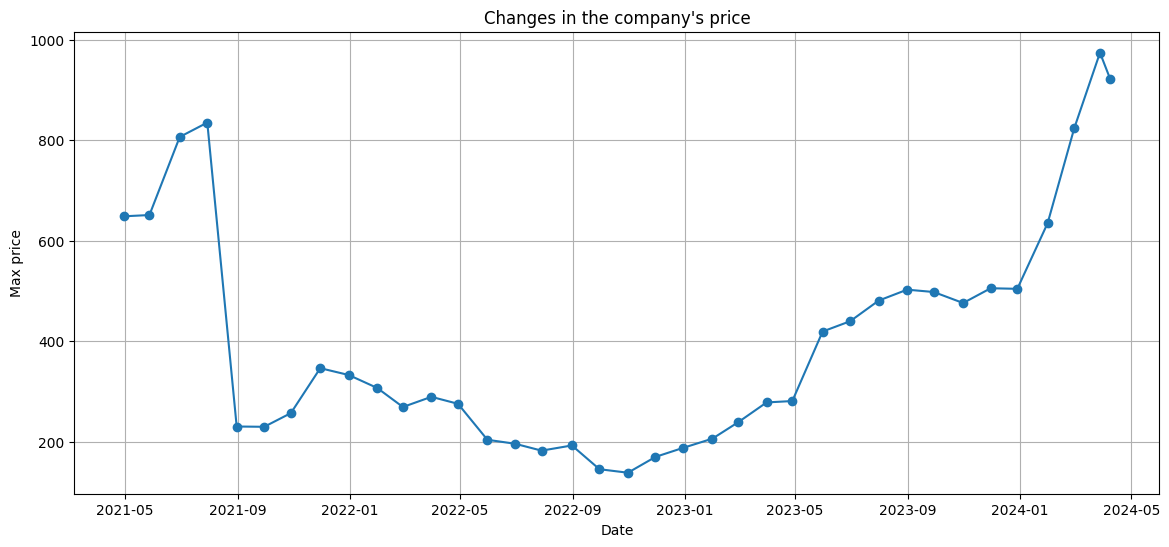

In [5]:
plt.figure(figsize=(14,6))
plt.plot(df.index, df['Max price'], marker='o', linestyle='-')
plt.title("Changes in the company's price")
plt.xlabel('Date')
plt.ylabel('Max price')
plt.grid(True)
plt.show()

In [6]:
outcome = adfuller(df['Max price'])
print('ADF статистика:', outcome[0])
print('p-значение:', outcome[1])
print('Критические значения:')
for key, value in outcome[4].items():
    print(f'{key}, {value}')

ADF статистика: -2.273694943256357
p-значение: 0.18059225751513774
Критические значения:
1%, -3.626651907578875
5%, -2.9459512825788754
10%, -2.6116707716049383


In [7]:
df['Max price'] = df['Max price'].astype(float)
df['Max price_copy'] = df['Max price']
transformed_data, lambda_value = boxcox(df['Max price_copy'])
df['Max price_boxcox'] = transformed_data
df['price_without_trend'] = df['Max price_boxcox'] - df['Max price_boxcox'].rolling(window=2).mean()
df['price_stationary'] = df['price_without_trend'].diff()
df.dropna(inplace=True)
df['price_without_trend_1'] = df['price_stationary'] - df['price_stationary'].rolling(window=2).mean()
df['price_stationary_1'] = df['price_without_trend_1'].diff()
df.dropna(inplace=True)

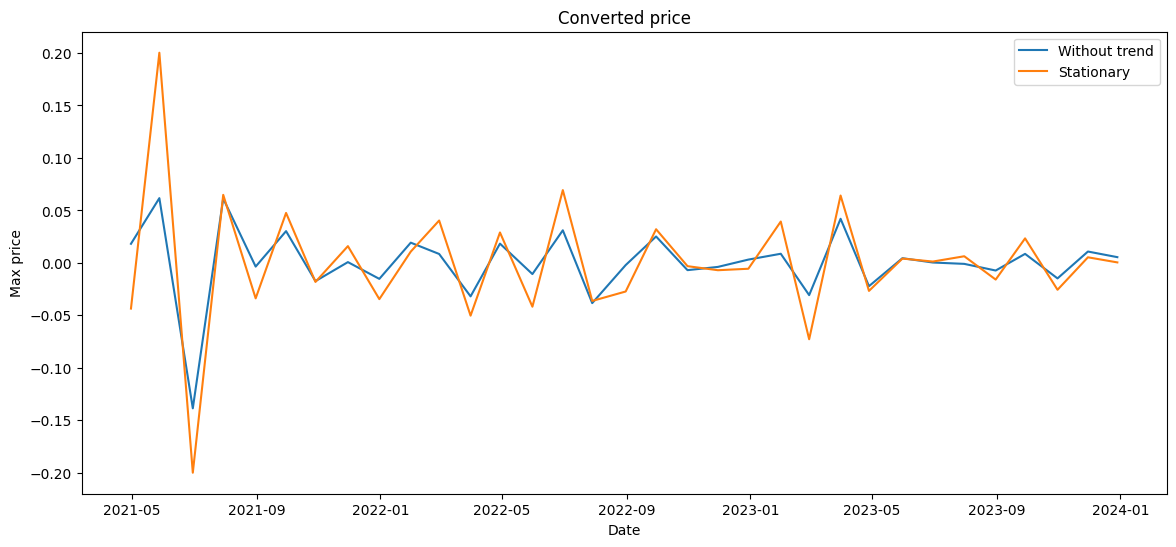

In [8]:
plt.figure(figsize=(14,6))
plt.plot(df.index, df['price_without_trend_1'], label = 'Without trend')
plt.plot(df.index, df['price_stationary_1'], label = 'Stationary')
plt.legend()
plt.title('Converted price')
plt.xlabel('Date')
plt.ylabel('Max price')
plt.show()

In [9]:
outcome = adfuller(df['price_stationary_1'])
print('ADF статистика:', outcome[0])
print('p-значение:', outcome[1])
print('Критические значения:')
for key, value in outcome[4].items():
    print(f'{key}, {value}')

ADF статистика: -3.2885694445393074
p-значение: 0.015397216630872828
Критические значения:
1%, -3.7529275211638033
5%, -2.998499866852963
10%, -2.6389669754253307


In [10]:
model = ARIMA(df['price_stationary_1'], order=(1, 1, 1))
model_fit = model.fit()
model_fit.summary()

/Users/user/Python Projects/data_science_project/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user/Python Projects/data_science_project/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user/Python Projects/data_science_project/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user/Python Projects/data_science_project/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     price_stationary_1   No. Observations:                   33
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  54.217
Date:                Mon, 22 Apr 2024   AIC                           -102.434
Time:                        23:33:40   BIC                            -98.037
Sample:                             0   HQIC                          -100.977
                                 - 33                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7205      0.076     -9.516      0.000      -0.869      -0.572
ma.L1         -0.9901      1.910     -0.518      0.604      -4.733       2.753
sigma2         0.0017      0.003      0.541      0.588      -0.004       0.008
===================================================================================
Ljung-Box (L1) (Q):                   2.68   Jarque-Bera (JB):                39.29
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):              10.43   Skew:                            -1.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
df

,Max price,Max price_copy,Max price_boxcox,price_without_trend,price_stationary,price_without_trend_1,price_stationary_1
Date,,,,,,,
2023-12-29,504.3299,504.3299,3.120060,-0.022888,0.001442,0.005490,0.000486
2023-11-30,505.4800,505.4800,3.120526,0.000233,0.023121,0.010840,0.005349
2023-10-31,476.0900,476.0900,3.108179,-0.006173,-0.006407,-0.014764,-0.025603
2023-09-29,498.0000,498.0000,3.117471,0.004646,0.010819,0.008613,0.023377
2023-08-31,502.6600,502.6600,3.119381,0.000955,-0.003691,-0.007255,-0.015868
2023-07-31,480.8800,480.8800,3.110255,-0.004563,-0.005518,-0.000913,0.006342
2023-06-30,439.9000,439.9000,3.091592,-0.009332,-0.004769,0.000374,0.001288
2023-05-31,419.3800,419.3800,3.081406,-0.005093,0.004239,0.004504,0.004130
2023-04-28,281.1000,281.1000,2.991053,-0.045176,-0.040083,-0.022161,-0.026665


In [12]:
forecast = model_fit.forecast(steps=36)[-33:]
mse = mean_squared_error(df['price_stationary_1'][-33:], forecast)
mae = mean_absolute_error(df['price_stationary_1'][-33:], forecast)
print(f'MSE: {mse}')
print(f'MAE: {mae}')

MSE: 0.0035983907229826
MAE: 0.039071869108587017


/Users/user/Python Projects/data_science_project/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/user/Python Projects/data_science_project/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


/Users/user/Python Projects/data_science_project/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/user/Python Projects/data_science_project/env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


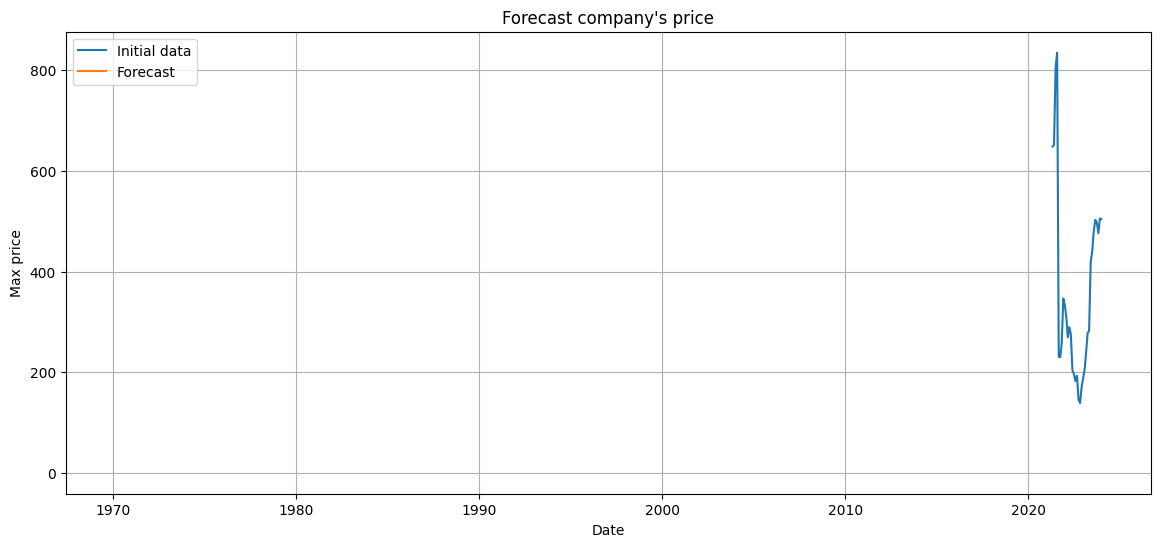

In [18]:
# весь этот блок одна сплошная проблема

forecast_future = model_fit.forecast(steps=1) # прогноз на будущее - 1 месяц

future_dates = pd.date_range(start='2024-04-22', periods=1, freq='ME')
forecast_df = pd.DataFrame({'Date future': future_dates, 'Forecast price': forecast_future}) # создаю датафрейм для будущих значений

df = pd.concat([df, forecast_df]) # присоединяю прогноз к исходному датафрейму

# блок визуализации
plt.figure(figsize=(14,6))
plt.plot(df.index[:-1], df['Max price'][:-1], label='Initial data')
plt.plot(df.index[-1:], df['Forecast price'][-1:], label='Forecast')
plt.title("Forecast company's price")
plt.xlabel('Date')
plt.ylabel('Max price')
plt.legend()
plt.grid(True)
plt.show()

# в итоге получаю график без прогноза, со смещенными датами, проверяю датафрейм - там новые колонки со значениями NaN и NaT, потенциально понимаю в какую сторону двигаться, но не понимаю как!